In [1]:
# Imports and stuff
import keras

import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.datasets import fetch_mldata

%matplotlib inline

# This is a helper function for later -- don't worry about this too much
def matconcat(arr, shp):
    return np.concatenate([np.concatenate([c for c in row], axis=1) 
                           for row in arr.reshape(*shp)], axis=0)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
import os
import tensorflow as tf
import librosa
import IPython
import numpy as np
import sklearn
#import sounddevice as sd
from glob import glob
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib notebook

# Digital Signal Processing

The goal of this project is to detect whether music is being played in an audio signal, and when.\n
General Approach:

1. Load files in 5 second chunks
2. Label chunks with "is_music"
3. Speech chunks -> 0
4. Music chunks -> 1
5. Create spectrograms from the chunks
6. Pass spectrogram data into neural net
7. ???
8. Profit


## Load data

In [3]:
music_filenames = np.array(glob('./data/music_audio/**/*.mp3'))
np.random.shuffle(music_filenames)
speech_filenames = np.array(glob('./data/speech_audio/*.mp3'))
np.random.shufflefle(speech_filenames)
len(music_filenames), len(speech_filenames)

(52, 50)

In [4]:
duration = 5            # duration in seconds (will only keep the X first seconds of the audio)
n_frequency_bins = 50   # number of frequency bins to keep (will keep the X lower frequency bins)

sample_rate = 22050     # Sample rate of the wav files

In [5]:
def get_spectrograms(filenames):
    audios = []
    spectrograms = []

    for filename in tqdm_notebook(filenames):
        try:
            audio, fs = librosa.load(filename)
            assert fs == sample_rate
            points = range(0, len(audio), int(fs*duration))
            for i in points[:int(len(points)/2)]:
                audio_ = audio[i:i+int(fs*duration)]
                spec = np.log(0.001 + np.abs(librosa.stft(audio_, n_fft=512, win_length=512, hop_length=512))[:n_frequency_bins])
                audios.append([audio_])
                spectrograms.append([spec])
        except:
            print(filename)

    audios = np.concatenate(audios)
    spectrograms = np.concatenate(spectrograms)
    return audios, spectrograms

In [6]:
num_train_m = int(0.5 + 0.75 * len(music_filenames))
num_train_s = int(0.5 + 0.75 * len(speech_filenames))
music_audios, music_spectrograms = get_spectrograms(music_filenames[:num_train_m])
speech_audios, speech_spectrograms = get_spectrograms(speech_filenames[:num_train_s])
music_audios_test, music_spectrograms_test = get_spectrograms(music_filenames[num_train_m:])
speech_audios_test, speech_spectrograms_test = get_spectrograms(speech_filenames[num_train_s:])

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [11]:
spect_shape = music_spectrograms[0].shape
music_spectrograms.shape, speech_spectrograms.shape, spect_shape

((1657, 50, 216), (1127, 50, 216), (50, 216))

## Music example

In [12]:
idx = np.random.randint(len(music_filenames))

IPython.display.Audio(music_audios[idx][:sample_rate * duration], rate=16000)

In [13]:
sp_idx = np.random.randint(len(speech_filenames))

IPython.display.Audio(speech_audios[idx][:sample_rate * duration], rate=16000)

In [14]:
def get_xy(music_spec, speech_spec, music_aud, speech_aud):
    X = np.concatenate((music_spec, speech_spec))
    audios = np.concatenate((music_aud, speech_aud))
    Y = np.concatenate((np.ones(len(music_spec), dtype=int), np.zeros(len(speech_spec), dtype=int)))
    shuff = np.arange(len(Y))
    np.random.shuffle(shuff)
    X = X[shuff]
    audios = audios[shuff]
    Y = Y[shuff]
    X = X.reshape(-1, 1, *spect_shape)
    Y = np.array([keras.utils.to_categorical(y, num_classes) for y in Y])
    return X, Y, audios

In [15]:
input_shape = (1, *spect_shape)
num_classes = 2

In [16]:
X_train, Y_train, audio_train = get_xy(music_spectrograms, speech_spectrograms, music_audios, speech_audios)
X_test, Y_test, audio_test = get_xy(music_spectrograms_test, speech_spectrograms_test, music_audios_test, speech_audios_test)

In [17]:
X_train.shape

(2784, 1, 50, 216)

<IPython.core.display.Javascript object>


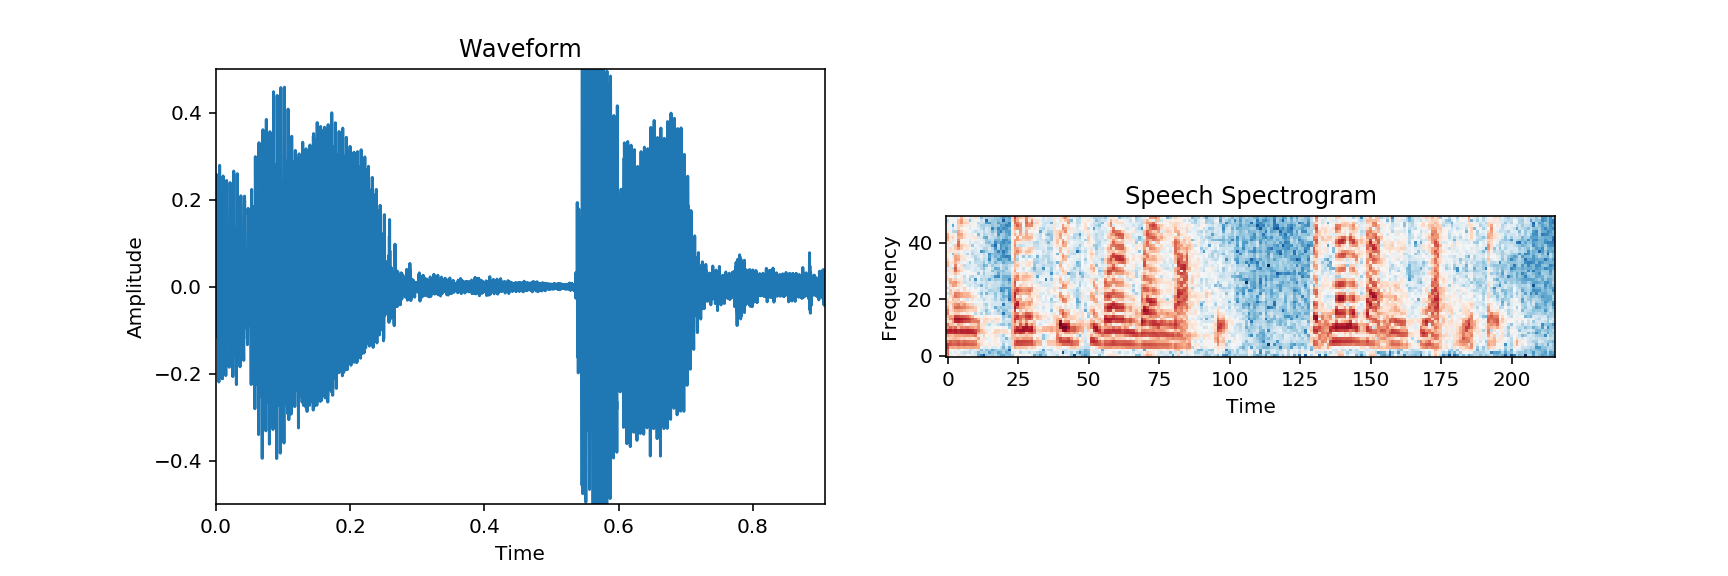

<IPython.core.display.Javascript object>


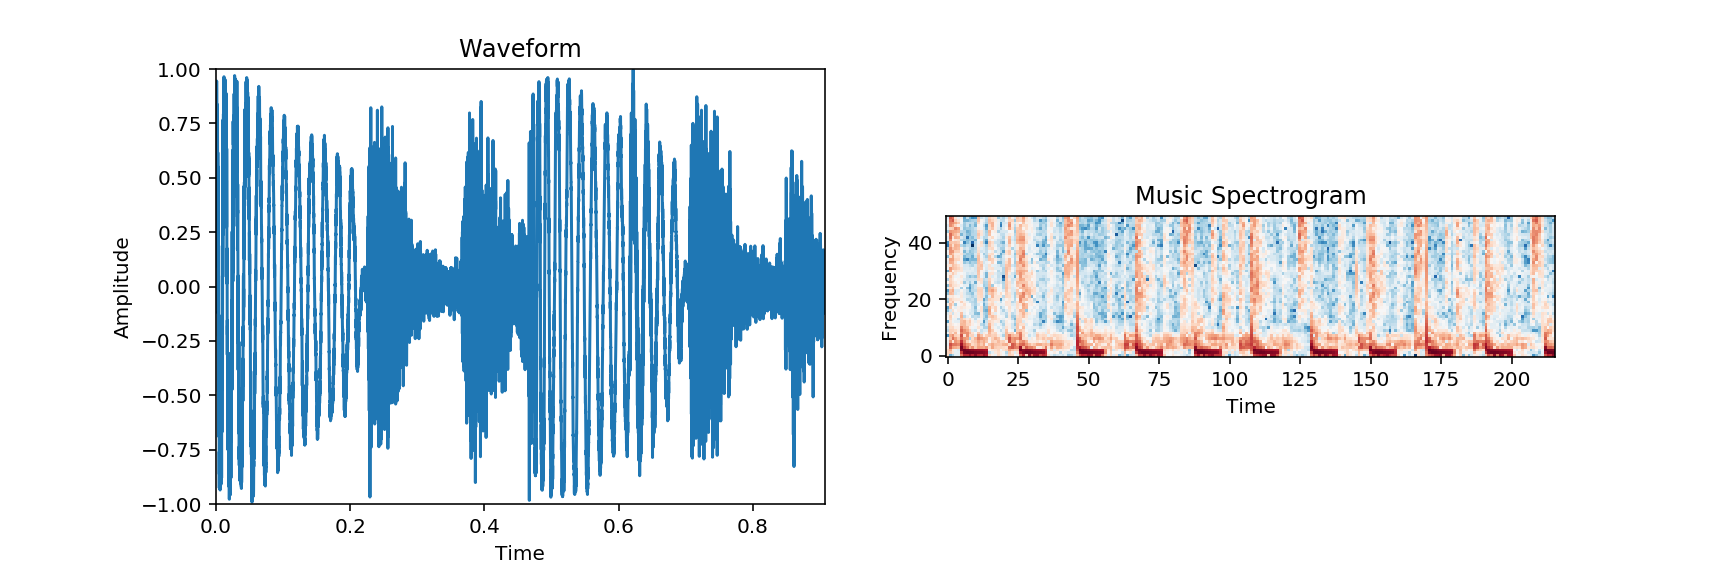

In [53]:
idx = np.random.randint(len(speech_filenames))

IPython.display.Audio(speech_audios[idx][:sample_rate * duration], rate=16000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.arange(20000) / sample_rate, speech_audios[idx][:20000])
ax1.set_xlim(0, 20000 / sample_rate)
ax1.set_ylim(-0.5, 0.5)
ax1.set_title("Waveform")
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude")

ax2.imshow(speech_spectrograms[idx], origin='lower', cmap='RdBu_r')
plt.title("Speech Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

fig.set_figheight(4)
fig.set_figwidth(12)

midx = np.random.randint(len(music_filenames))

IPython.display.Audio(music_audios[midx][:sample_rate * duration], rate=16000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.arange(20000) / sample_rate, music_audios[idx][:20000])
ax1.set_xlim(0, 20000 / sample_rate)
ax1.set_ylim(-1, 1)
ax1.set_title("Waveform")
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude")

ax2.imshow(music_spectrograms[midx], origin='lower', cmap='RdBu_r')
plt.title("Music Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

fig.set_figheight(4)
fig.set_figwidth(12)

## Model 1: Simple CNN

In [19]:
first_net = Sequential()
first_net.add(Conv2D(filters=12, kernel_size=(12, 12), strides=(4, 4),
                    activation='relu', padding='valid',
                    data_format='channels_first',
                    input_shape=input_shape))
first_net.add(Flatten())
first_net.add(Dense(num_classes, activation='softmax'))

first_net.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.SGD(),
                 metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
first_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 10, 52)        1740      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6240)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12482     
Total params: 14,222
Trainable params: 14,222
Non-trainable params: 0
_________________________________________________________________


In [24]:
Y_train = Y_train.reshape(Y_train.shape[0],Y_train.shape[2])


In [27]:
Y_test = Y_test.reshape(Y_test.shape[0],Y_test.shape[2])

In [28]:
first_history = first_net.fit(X_train, Y_train,
                              batch_size=64,
                              epochs=10, verbose=1,
                              validation_data=(X_test, Y_test))

Train on 2784 samples, validate on 923 samples
Epoch 1/10
2784/2784 [==============================] - 3s - loss: 0.2883 - acc: 0.9041 - val_loss: 0.2209 - val_acc: 0.9458
Epoch 2/10
2784/2784 [==============================] - 2s - loss: 0.0881 - acc: 0.9741 - val_loss: 0.1823 - val_acc: 0.9567
Epoch 3/10
2784/2784 [==============================] - 2s - loss: 0.0715 - acc: 0.9795 - val_loss: 0.1597 - val_acc: 0.9632
Epoch 4/10
2784/2784 [==============================] - 2s - loss: 0.0581 - acc: 0.9842 - val_loss: 0.1795 - val_acc: 0.9632
Epoch 5/10
2784/2784 [==============================] - 2s - loss: 0.0511 - acc: 0.9853 - val_loss: 0.1819 - val_acc: 0.9621
Epoch 6/10
2784/2784 [==============================] - 2s - loss: 0.0429 - acc: 0.9871 - val_loss: 0.1932 - val_acc: 0.9632
Epoch 7/10
2784/2784 [==============================] - 2s - loss: 0.0387 - acc: 0.9889 - val_loss: 0.1689 - val_acc: 0.9664
Epoch 8/10
2784/2784 [==============================] - 2s - loss: 0.0362 - ac

In [29]:
def plot_history(hist):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Loss
    axes[0].plot(hist.epoch, hist.history['loss'], label='Training')
    axes[0].plot(hist.epoch, hist.history['val_loss'], label='Test')
    axes[0].set_ylim(0, max(hist.history['loss'] + hist.history['val_loss']))
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")

    # Accuracy
    axes[1].plot(hist.epoch, hist.history['acc'], label='Training')
    axes[1].plot(hist.epoch, hist.history['val_acc'], label='Test')
    axes[1].set_ylim(min(hist.history['acc'] + hist.history['val_acc']), 1)
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")

    plt.legend(loc='best')
    plt.tight_layout()

<IPython.core.display.Javascript object>


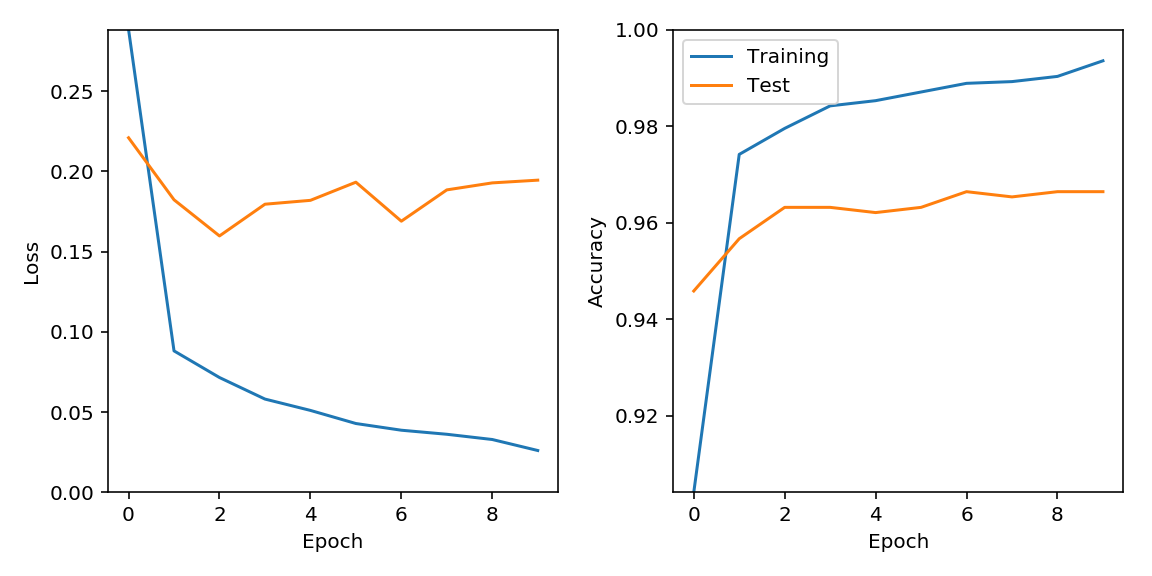

In [30]:
plot_history(first_history)

In [37]:
# # Visualize the weights of the network
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
# for w, ax in zip(first_net.get_weights()[0], 
#                  axes.flatten()):
#     ax.imshow(matconcat(w.reshape(3, 4, 12).transpose(2, 0, 1), (3, 4, 3, 4)), cmap='RdBu_r')
#     ax.set_xticks([]), ax.set_yticks([])

# # fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(6, 3))
# # for w, ax in zip(first_net.get_weights()[2].reshape(5, 5, 12, 10).transpose(3, 2, 0, 1), 
# #                  axes.flatten()):
# #     ax.imshow(matconcat(w, (3, 4, 5, 5)), cmap='RdBu_r')
# #     ax.set_xticks([]), ax.set_yticks([])

# plt.tight_layout()

## Model 2: CNN with Max Pooling

In [31]:
second_net = Sequential()
second_net.add(Conv2D(filters=12, kernel_size=(9, 12), strides=(4, 4),
                    activation='relu', padding='valid',
                    data_format='channels_first',
                    input_shape=input_shape))
second_net.add(MaxPool2D(pool_size=(3, 4), data_format='channels_first'))
second_net.add(Flatten())
second_net.add(Dense(num_classes, activation='softmax'))

second_net.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.SGD(),
                 metrics=['accuracy'])

In [32]:
second_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 12, 11, 52)        1308      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 3, 13)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 468)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 938       
Total params: 2,246
Trainable params: 2,246
Non-trainable params: 0
_________________________________________________________________


In [33]:
second_history = second_net.fit(X_train, Y_train,
                              batch_size=32,
                              epochs=5, verbose=1,
                              validation_data=(X_test, Y_test))

Train on 2784 samples, validate on 923 samples
Epoch 1/5
2784/2784 [==============================] - 3s - loss: 0.2154 - acc: 0.9228 - val_loss: 0.1884 - val_acc: 0.9556
Epoch 2/5
2784/2784 [==============================] - 2s - loss: 0.0897 - acc: 0.9734 - val_loss: 0.1757 - val_acc: 0.9556
Epoch 3/5
2784/2784 [==============================] - 2s - loss: 0.0663 - acc: 0.9828 - val_loss: 0.1774 - val_acc: 0.9599
Epoch 4/5
2784/2784 [==============================] - 2s - loss: 0.0564 - acc: 0.9853 - val_loss: 0.1697 - val_acc: 0.9610
Epoch 5/5
2784/2784 [==============================] - 2s - loss: 0.0491 - acc: 0.9867 - val_loss: 0.1778 - val_acc: 0.9621


<IPython.core.display.Javascript object>


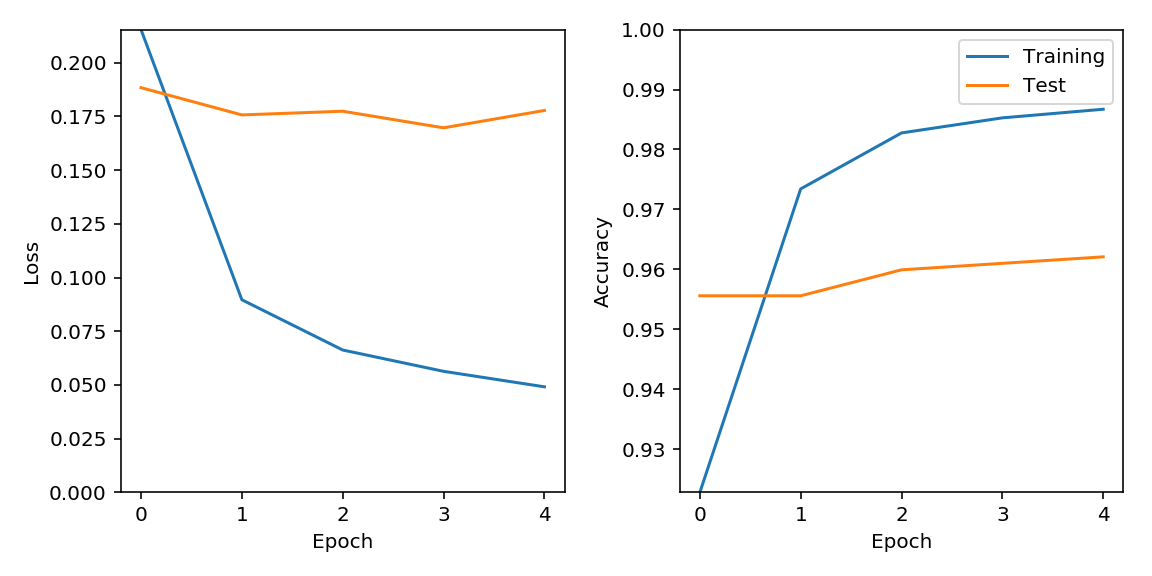

In [34]:
plot_history(second_history)

## Model 3: CNN with Max Pooling and Dropout

In [35]:
from keras.layers import Dropout

third_net = Sequential()
third_net.add(Conv2D(filters=12, kernel_size=(9, 9), strides=(4, 4),
                    activation='relu', padding='valid',
                    data_format='channels_first',
                    input_shape=input_shape))
third_net.add(Dropout(0.3))
third_net.add(MaxPool2D(pool_size=(3, 3), data_format='channels_first'))
third_net.add(Flatten())
third_net.add(Dense(num_classes, activation='softmax'))

third_net.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.SGD(),
                 metrics=['accuracy'])

In [36]:
third_history = third_net.fit(X_train, Y_train,
                              batch_size=64,
                              epochs=5, verbose=1,
                              validation_data=(X_test, Y_test))

Train on 2784 samples, validate on 923 samples
Epoch 1/5
2784/2784 [==============================] - 3s - loss: 0.2717 - acc: 0.8847 - val_loss: 0.2460 - val_acc: 0.9328
Epoch 2/5
2784/2784 [==============================] - 2s - loss: 0.1204 - acc: 0.9626 - val_loss: 0.1981 - val_acc: 0.9458
Epoch 3/5
2784/2784 [==============================] - 2s - loss: 0.0929 - acc: 0.9709 - val_loss: 0.1940 - val_acc: 0.9523
Epoch 4/5
2784/2784 [==============================] - 2s - loss: 0.0807 - acc: 0.9763 - val_loss: 0.1849 - val_acc: 0.9545
Epoch 5/5
2784/2784 [==============================] - 3s - loss: 0.0719 - acc: 0.9770 - val_loss: 0.1898 - val_acc: 0.9545


In [37]:
third_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 12, 11, 52)        984       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 11, 52)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 3, 17)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 612)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1226      
Total params: 2,210
Trainable params: 2,210
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>


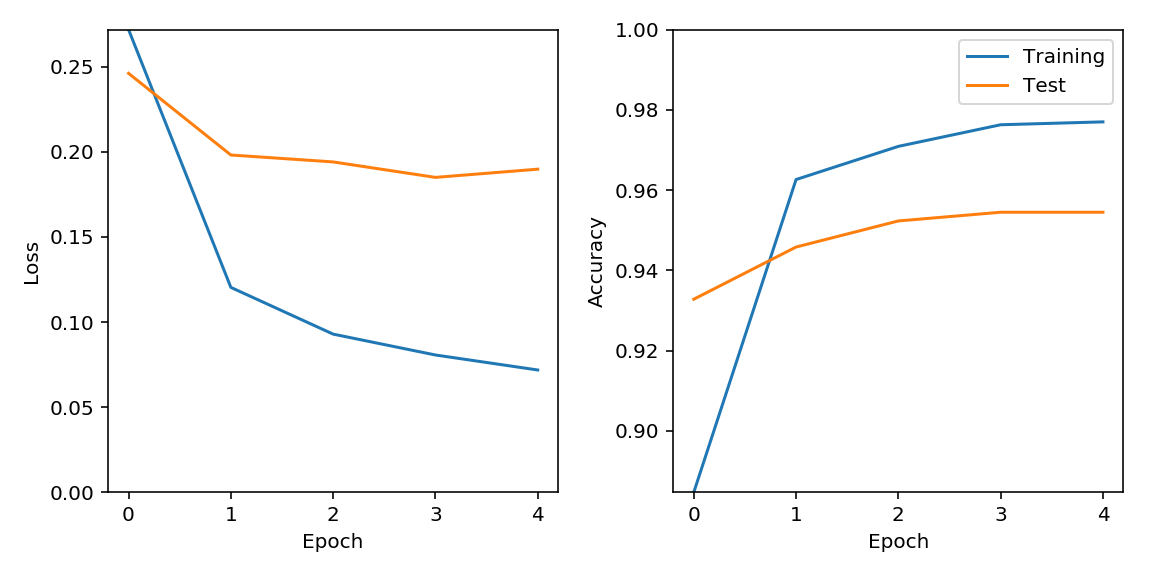

In [38]:
plot_history(third_history)

## Model 4: 2 layer LSTM

In [39]:
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

In [62]:
X_lstm = X_train.reshape(-1, *spect_shape)
X_lstm.shape
X_lstm_test = X_test.reshape(-1, *spect_shape)

In [63]:
m, n_values, Tx = X_lstm.shape
X_lstm = X_lstm.reshape(m, Tx, n_values )
m, n_values, Tx = X_lstm_test.shape
X_lstm_test = X_lstm_test.reshape(m, Tx, n_values )

def audio_model(input_shape):

    indices = Input(shape = input_shape, dtype = 'float32')

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X_lstm = LSTM(128, return_sequences=True)(indices)
    # Add dropout with a probability of 0.5
    X_lstm = Dropout(0.5)(X_lstm)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    X_lstm = LSTM(128, return_sequences=False)(X_lstm)
    # Add dropout with a probability of 0.5
    X_lstm = Dropout(0.5)(X_lstm)
    X_lstm = Dense(2)(X_lstm)
    # Add a softmax activation
    X_lstm = Activation('softmax')(X_lstm)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(input = indices, output = X_lstm)
    
    
    return model

In [64]:
model = audio_model((216, 50))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 216, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 216, 128)          91648     
_________________________________________________________________
dropout_6 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total para

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = model.fit(X_lstm, Y_train, epochs = 6, batch_size = 32, shuffle=True, validation_data=(X_lstm_test, Y_test))

Train on 2784 samples, validate on 923 samples
Epoch 1/6
2784/2784 [==============================] - 67s - loss: 0.3456 - acc: 0.8556 - val_loss: 0.1367 - val_acc: 0.9447
Epoch 2/6
2784/2784 [==============================] - 68s - loss: 0.1336 - acc: 0.9616 - val_loss: 0.0979 - val_acc: 0.9686
Epoch 3/6
2784/2784 [==============================] - 65s - loss: 0.0856 - acc: 0.9767 - val_loss: 0.0485 - val_acc: 0.9848
Epoch 4/6
2784/2784 [==============================] - 65s - loss: 0.0924 - acc: 0.9731 - val_loss: 0.0691 - val_acc: 0.9772
Epoch 5/6
2784/2784 [==============================] - 62s - loss: 0.0714 - acc: 0.9828 - val_loss: 0.0743 - val_acc: 0.9751
Epoch 6/6
2784/2784 [==============================] - 62s - loss: 0.0671 - acc: 0.9828 - val_loss: 0.0313 - val_acc: 0.9892


<IPython.core.display.Javascript object>


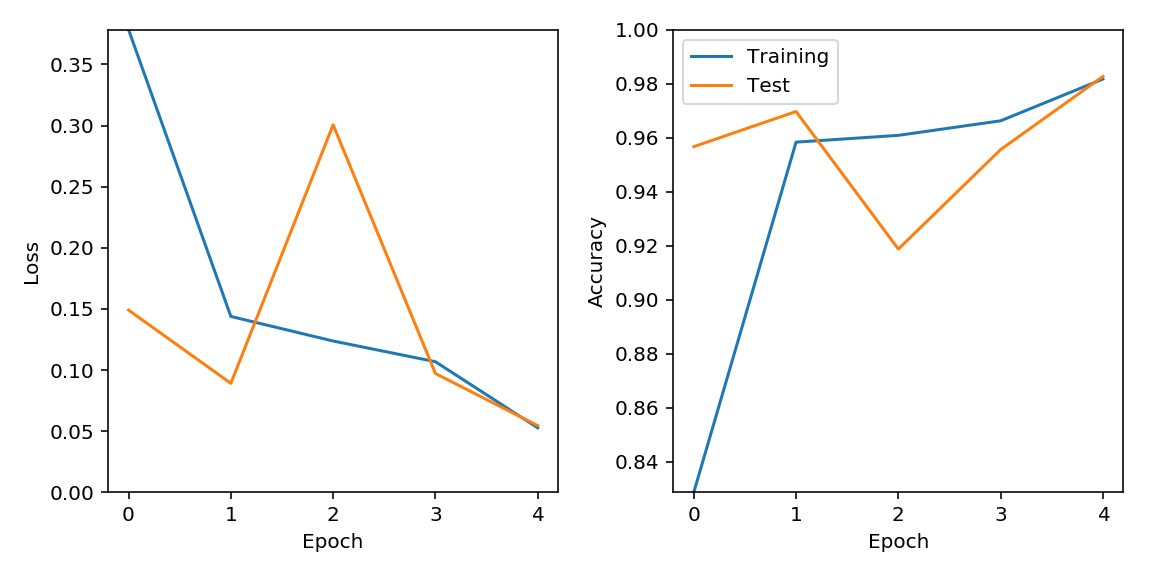

In [44]:
plot_history(lstm_history)

In [47]:
correct = audio_test[np.where(np.argmax(Y_test, axis=1)==np.argmax(model.predict(X_lstm_test), axis=1))]
inc = audio_test[np.where(np.argmax(Y_test, axis=1)!=np.argmax(model.predict(X_lstm_test), axis=1))]

In [54]:
correct.shape

(907, 110250)

In [55]:
inc.shape

(16, 110250)

## Incorrectly labeled test (LSTM)

In [7]:
idx = np.random.randint(len(inc))

IPython.display.Audio(inc[idx][:sample_rate * duration], rate=16000)

NameError: name 'inc' is not defined

In [50]:
idx = np.random.randint(len(inc))

IPython.display.Audio(inc[idx][:sample_rate * duration], rate=16000)

In [57]:
idx = np.random.randint(len(inc))

IPython.display.Audio(inc[idx][:sample_rate * duration], rate=16000)